## Run me on colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rjlopez2/ADS_CAS_Bern_2020/blob/main/Projects/M1%20and%20M2/M1M2_cas_project.ipynb)


### **Import libraries**

In [1]:
import pandas as pd
#!pip install wget # uncomment this igf you run it via colab
import os
from zipfile import ZipFile
import numpy as np
import wget
import fnmatch
import requests
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

# Part I 
# M1 project 

## On data aquisition, formating and cleaning

# 1. John Hopkins data collection and cleaning
### **Download the time series datasets on global Covid cases from the John Hpkins University**
The time series are organized in 3 different files from their Github repository:

 - one file retrieve information on the confirmed cases
 - one file retrieve information on the death cases
 - one file retrieve information on the recovered cases

Below we download the 3 datastes and store them locally in .csv format.

In [2]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

path = os.getcwd() # get the current directory

for url in urls:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
    
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [3]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### **We explore below the structure of the 3 datasets**

By looking at the shape of the 3 df, we observe that the recovered_df has different dimention than the two others.
Closer inspection revealed that 14 provinces from Canada were missed in the recovered_df.

In [4]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(269, 302), (269, 302), (256, 302)]


In [5]:
confirmed_df[~confirmed_df['Province/State'].isin(recovered_df['Province/State'])][['Province/State', 'Country/Region']] # !!! 14 'Province/State'  no found in the recovered_df

Province/State Country/Region
39                    Alberta         Canada
40           British Columbia         Canada
41           Diamond Princess         Canada
42             Grand Princess         Canada
43                   Manitoba         Canada
44              New Brunswick         Canada
45  Newfoundland and Labrador         Canada
46      Northwest Territories         Canada
47                Nova Scotia         Canada
48                    Ontario         Canada
49       Prince Edward Island         Canada
50                     Quebec         Canada
51               Saskatchewan         Canada
52                      Yukon         Canada

Because of this inconsistency, we decided to exclude data from Canada for now.

In [6]:
recovered_df = recovered_df[recovered_df['Country/Region']!='Canada']
confirmed_df = confirmed_df[confirmed_df['Country/Region']!='Canada']
deaths_df = deaths_df[deaths_df['Country/Region']!='Canada']

In [7]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(255, 302), (255, 302), (255, 302)]


We observed that the first 4 colums of each dataset have the same variables so we use them to merge all 3 datasets and we define the time variable with the rest of the colums

1. We create the vector for the time varibale
2. we transform the 3 dataframes to long format. 

In [8]:
recovered_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '11/5/20', '11/6/20', '11/7/20', '11/8/20', '11/9/20', '11/10/20',
       '11/11/20', '11/12/20', '11/13/20', '11/14/20'],
      dtype='object', length=302)

In [9]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '11/5/20', '11/6/20', '11/7/20', '11/8/20', '11/9/20', '11/10/20',
       '11/11/20', '11/12/20', '11/13/20', '11/14/20'],
      dtype='object', length=302)

In [10]:
confirmed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '11/5/20', '11/6/20', '11/7/20', '11/8/20', '11/9/20', '11/10/20',
       '11/11/20', '11/12/20', '11/13/20', '11/14/20'],
      dtype='object', length=302)

In [11]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [12]:
# check the size of each dataset in long format
print([confirmed_df_long.shape, deaths_df_long.shape, recovered_df_long.shape])

[(75990, 6), (75990, 6), (75990, 6)]


In [13]:
# check if the number of countries are the same in each subset
print(confirmed_df_long['Country/Region'].drop_duplicates().shape, 
      deaths_df_long['Country/Region'].drop_duplicates().shape, 
      recovered_df_long['Country/Region'].drop_duplicates().shape)
      

(190,) (190,) (190,)


In [14]:
confirmed_df_long

Province/State      Country/Region        Lat       Long      Date  \
0                NaN         Afghanistan  33.939110  67.709953   1/22/20   
1                NaN             Albania  41.153300  20.168300   1/22/20   
2                NaN             Algeria  28.033900   1.659600   1/22/20   
3                NaN             Andorra  42.506300   1.521800   1/22/20   
4                NaN              Angola -11.202700  17.873900   1/22/20   
...              ...                 ...        ...        ...       ...   
75985            NaN  West Bank and Gaza  31.952200  35.233200  11/14/20   
75986            NaN      Western Sahara  24.215500 -12.885800  11/14/20   
75987            NaN               Yemen  15.552727  48.516388  11/14/20   
75988            NaN              Zambia -13.133897  27.849332  11/14/20   
75989            NaN            Zimbabwe -19.015438  29.154857  11/14/20   

       Confirmed  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
75985      62167  
75986         10  
75987       2072  
75988      17097  
75989       8786  

[75990 rows x 6 columns]

In [15]:
# Merge the 3 datasets 

confirmed_df_long["Deaths"] = deaths_df_long["Deaths"]
confirmed_df_long["Recovered"] = recovered_df_long['Recovered']
full_table = confirmed_df_long

In [16]:
full_table.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75990 entries, 0 to 75989
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  19966 non-null  object 
 1   Country/Region  75990 non-null  object 
 2   Lat             75990 non-null  float64
 3   Long            75990 non-null  float64
 4   Date            75990 non-null  object 
 5   Confirmed       75990 non-null  int64  
 6   Deaths          75990 non-null  int64  
 7   Recovered       75990 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 4.6+ MB


In [17]:
# trasnform from string to date the "Date" column
full_table['Date'] = pd.to_datetime(full_table['Date'])

### **Check and fix NaN in the full dataset**

In [18]:
full_table.isna().sum()

Province/State    56024
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

### **Remove cruise ships data**
 #### We also observed that there is some of confirmed cases of Covid from the cruise ships (Grand Princess, Diamond Princess and MS Zaandam) that make it difficult to fit in in the Country category, so we excluded from our anaysis

In [19]:
# select the ships rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

In [20]:
full_table = full_table[~(ship_rows)] # the '~' operator negate the selections

## **Add new colum for active cases**
Below we compute the active cases by substracting the number of death and recovered to the confirmed cases.

In [21]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Province/State      Country/Region        Lat       Long       Date  \
0                NaN         Afghanistan  33.939110  67.709953 2020-01-22   
1                NaN             Albania  41.153300  20.168300 2020-01-22   
2                NaN             Algeria  28.033900   1.659600 2020-01-22   
3                NaN             Andorra  42.506300   1.521800 2020-01-22   
4                NaN              Angola -11.202700  17.873900 2020-01-22   
...              ...                 ...        ...        ...        ...   
75985            NaN  West Bank and Gaza  31.952200  35.233200 2020-11-14   
75986            NaN      Western Sahara  24.215500 -12.885800 2020-11-14   
75987            NaN               Yemen  15.552727  48.516388 2020-11-14   
75988            NaN              Zambia -13.133897  27.849332 2020-11-14   
75989            NaN            Zimbabwe -19.015438  29.154857 2020-11-14   

       Confirmed  Deaths  Recovered  Active  
0              0       0          0       0  
1              0       0          0       0  
2              0       0          0       0  
3              0       0          0       0  
4              0       0          0       0  
...          ...     ...        ...     ...  
75985      62167     558      53791    7818  
75986         10       1          8       1  
75987       2072     605       1394      73  
75988      17097     350      16137     610  
75989       8786     257       8096     433  

[75394 rows x 9 columns]

We agregate the data by Country and Date (by means of grouping) and calculate de sum of the cases

In [22]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

full_grouped

Date      Country/Region  Confirmed  Deaths  Recovered  Active
0     2020-01-22         Afghanistan          0       0          0       0
1     2020-01-22             Albania          0       0          0       0
2     2020-01-22             Algeria          0       0          0       0
3     2020-01-22             Andorra          0       0          0       0
4     2020-01-22              Angola          0       0          0       0
...          ...                 ...        ...     ...        ...     ...
56019 2020-11-14  West Bank and Gaza      62167     558      53791    7818
56020 2020-11-14      Western Sahara         10       1          8       1
56021 2020-11-14               Yemen       2072     605       1394      73
56022 2020-11-14              Zambia      17097     350      16137     610
56023 2020-11-14            Zimbabwe       8786     257       8096     433

[56024 rows x 6 columns]

## Add new column(s) for new cases / new deaths / new recovered

In [23]:
# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New_cases', 'New_deaths', 'New_recovered']

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New_cases', 'New_deaths', 'New_recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

# 
full_grouped['New_cases'] = full_grouped['New_cases'].apply(lambda x: 0 if x<0 else x)

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [24]:
#rename the "Country/Region" variable
full_grouped.rename(columns = {'Country/Region' : 'Country_Region'}, inplace = True)


In [25]:
# compute the number of countries registered in the covide dataset
full_grouped['Country_Region'].unique().size

188

## **Extract metadata for Covid datasets**
We want to merge the covid dataset with other datasets by a comun variable, in our case is the Country. To make sure that the union of datasets are compatible, and since countries might be named disticntly  from each dataset source we use the country code as an standard varibale fro later merge. Now we asign to the Covid dataframe a new colum for the Country codes. To achieve this task we do the following steps: 
 - Load metadata from the Covid repository
 - Extract the information on Country code (here is the variable called 'iso3')

We also extract additional information on the population from each country. this will be used later for normalizing our variables.

In [26]:
covid_metadata_countries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv",
                                      usecols = ['Country_Region', 'Province_State', 'iso3', 'Population'])


In [27]:
covid_metadata_countries.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4169 entries, 0 to 4168
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso3            4167 non-null   object 
 1   Province_State  3978 non-null   object 
 2   Country_Region  4169 non-null   object 
 3   Population      4027 non-null   float64
dtypes: float64(1), object(3)
memory usage: 130.4+ KB


### **Remove regional subset in hte metadata and only work at national level**

In [28]:
covid_metadata_countries = covid_metadata_countries[covid_metadata_countries['Province_State'].isna()].drop_duplicates()#.shape

### **Remove the cruise ships information from the metadata on country codes**

In [29]:
# select from columns 'Country_Region' the names 'Diamond Princess'and 'MS Zaandam'
ship_metadata = covid_metadata_countries['Country_Region'].str.contains('Diamond Princess') | covid_metadata_countries['Country_Region'].str.contains('MS Zaandam')
ship_metadata
covid_metadata_countries = covid_metadata_countries[~(ship_metadata)]

### **Summarize the population by country in the metadata dataframe**

In [30]:
#my_covid_variables = ['Confirmed', 'Deaths', 'Recovered', 'Active']
code_vars = ['Country_Region', 'iso3']

#full_table.groupby(['Date', 'Country/Region'])[my_covid_variables].sum().reset_index()
country_population = covid_metadata_countries.groupby(code_vars)['Population'].sum().reset_index()

In [31]:
country_population['Country_Region'].unique().shape

(189,)

In [32]:
# this is the number of countries registered in the Covid df
full_grouped['Country_Region'].unique().size

188

### **Merge country code with Covid datasets**

In [33]:
full_grouped_ccode = pd.merge(country_population, full_grouped, how = 'left')


In [34]:
full_grouped_ccode.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56025 entries, 0 to 56024
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  56025 non-null  object        
 1   iso3            56025 non-null  object        
 2   Population      56025 non-null  float64       
 3   Date            56024 non-null  datetime64[ns]
 4   Confirmed       56024 non-null  float64       
 5   Deaths          56024 non-null  float64       
 6   Recovered       56024 non-null  float64       
 7   Active          56024 non-null  float64       
 8   New_cases       56024 non-null  float64       
 9   New_deaths      56024 non-null  float64       
 10  New_recovered   56024 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.1+ MB


In [35]:
full_grouped_ccode.rename(columns = {'iso3' : 'CountryCode'}, inplace = True)

In [36]:
# Check NaNs generated during the merge and remove them
full_grouped_ccode.isna().sum()

Country_Region    0
CountryCode       0
Population        0
Date              1
Confirmed         1
Deaths            1
Recovered         1
Active            1
New_cases         1
New_deaths        1
New_recovered     1
dtype: int64

In [37]:
full_grouped_ccode = full_grouped_ccode[~full_grouped_ccode['Date'].isna()]

# 2. Oxford Stringency index data collection, cleaning and merging

In [38]:
str_url = ["https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"]

for url in str_url:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [39]:
my_string_columns = ["Date", "CountryCode", "CountryName", "StringencyIndex", "RegionName", "RegionCode"] 
stringency_raw_dataset = pd.read_csv("OxCGRT_latest.csv", usecols = my_string_columns, low_memory=False)
stringency_raw_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78080 entries, 0 to 78079
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CountryName      78080 non-null  object 
 1   CountryCode      78080 non-null  object 
 2   RegionName       17920 non-null  object 
 3   RegionCode       17920 non-null  object 
 4   Date             78080 non-null  int64  
 5   StringencyIndex  74270 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.6+ MB


### **Selecting national data only ( exclude regional data) read documentation in this link why -> https://github.com/OxCGRT/covid-policy-tracker**
To take only the natinal data we followed instructions in the link above and take only rows where the variable RegionCoide is Null

In [40]:
stringe_natio_dataset = stringency_raw_dataset[stringency_raw_dataset.RegionCode.isnull()]


In [41]:
# remove columns with no needed information
stringe_natio_dataset = stringe_natio_dataset[my_string_columns[:4]]

Closer inspection revealed that the number of country codes from the Stringency dataset is less than the number of country codes in the Covid dataframe.


In [42]:
print([stringe_natio_dataset['CountryCode'].unique().size, 
       full_grouped_ccode['CountryCode'].unique().size])


[188, 188]


#### **The list below shows the Countries/region/dependencies which have not information regarding stringency index. Those countries (31) will be excluded form the analysis for the momment**

In [43]:
# finding What is not present in the stringency dataset
full_grouped_ccode[~full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])][['CountryCode', 'Country_Region']].drop_duplicates()

CountryCode                    Country_Region
1490          ATG               Antigua and Barbuda
2086          ARM                           Armenia
3278          BHS                           Bahamas
15795         GNQ                 Equatorial Guinea
19967         GRD                           Grenada
20861         GNB                     Guinea-Bissau
21755         VAT                          Holy See
26821         XKS                            Kosovo
29503         LIE                     Liechtenstein
31291         MDV                          Maldives
31887         MLT                             Malta
32185         MHL                  Marshall Islands
34271         MNE                        Montenegro
37251         MKD                   North Macedonia
41721         KNA             Saint Kitts and Nevis
42019         LCA                       Saint Lucia
42317         VCT  Saint Vincent and the Grenadines
42913         STP             Sao Tome and Principe
54833         ESH                    Western Sahara

In [44]:
## We filtered out the countries above for joining with the covid dataset
full_grouped_ccode_filtered = full_grouped_ccode[full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])]

In [45]:
full_grouped_ccode_filtered.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50362 entries, 0 to 56024
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  50362 non-null  object        
 1   CountryCode     50362 non-null  object        
 2   Population      50362 non-null  float64       
 3   Date            50362 non-null  datetime64[ns]
 4   Confirmed       50362 non-null  float64       
 5   Deaths          50362 non-null  float64       
 6   Recovered       50362 non-null  float64       
 7   Active          50362 non-null  float64       
 8   New_cases       50362 non-null  float64       
 9   New_deaths      50362 non-null  float64       
 10  New_recovered   50362 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 4.6+ MB


### Fixing the date format in the stringency dataset

In [46]:
#stringency_raw_dataset.info(verbose = True)
stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')

In [47]:
stringe_natio_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60160 entries, 0 to 78079
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             60160 non-null  datetime64[ns]
 1   CountryCode      60160 non-null  object        
 2   CountryName      60160 non-null  object        
 3   StringencyIndex  57258 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.3+ MB


In [48]:
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex
0     2020-01-01         ABW       Aruba              0.0
1     2020-01-02         ABW       Aruba              0.0
2     2020-01-03         ABW       Aruba              0.0
3     2020-01-04         ABW       Aruba              0.0
4     2020-01-05         ABW       Aruba              0.0
...          ...         ...         ...              ...
78075 2020-11-11         ZWE    Zimbabwe              NaN
78076 2020-11-12         ZWE    Zimbabwe              NaN
78077 2020-11-13         ZWE    Zimbabwe              NaN
78078 2020-11-14         ZWE    Zimbabwe              NaN
78079 2020-11-15         ZWE    Zimbabwe              NaN

[60160 rows x 4 columns]

### Create categories for Stringency index

In [49]:
condition1 = (stringe_natio_dataset["StringencyIndex"] >= 0) & (stringe_natio_dataset["StringencyIndex"] <= 20)
condition2 = (stringe_natio_dataset["StringencyIndex"] > 20) & (stringe_natio_dataset["StringencyIndex"] <= 40)
condition3 = (stringe_natio_dataset["StringencyIndex"] > 40) & (stringe_natio_dataset["StringencyIndex"] <= 60)
condition4 = (stringe_natio_dataset["StringencyIndex"] > 60) & (stringe_natio_dataset["StringencyIndex"] <= 80)
condition5 = (stringe_natio_dataset["StringencyIndex"] > 80) & (stringe_natio_dataset["StringencyIndex"] <= 100)

case1 = "Very_low"
case2 = "Low"
case3 = "Middle"
case4 = "High"
case5 = "Very_high"


stringe_natio_dataset["StringencyIndex_factor"] = np.where(condition1, case1, 
                                                    np.where(condition2, case2, 
                                                            np.where(condition3, case3,
                                                                    np.where(condition3, case3,
                                                                            np.where(condition4, case4,
                                                                                    np.where(condition5, case5,
                                                                                            "unknown"))))))
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex  \
0     2020-01-01         ABW       Aruba              0.0   
1     2020-01-02         ABW       Aruba              0.0   
2     2020-01-03         ABW       Aruba              0.0   
3     2020-01-04         ABW       Aruba              0.0   
4     2020-01-05         ABW       Aruba              0.0   
...          ...         ...         ...              ...   
78075 2020-11-11         ZWE    Zimbabwe              NaN   
78076 2020-11-12         ZWE    Zimbabwe              NaN   
78077 2020-11-13         ZWE    Zimbabwe              NaN   
78078 2020-11-14         ZWE    Zimbabwe              NaN   
78079 2020-11-15         ZWE    Zimbabwe              NaN   

      StringencyIndex_factor  
0                   Very_low  
1                   Very_low  
2                   Very_low  
3                   Very_low  
4                   Very_low  
...                      ...  
78075                unknown  
78076                unknown  
78077                unknown  
78078                unknown  
78079                unknown  

[60160 rows x 5 columns]

# 3. Joining Covid cases with Stringency index data 
Join the covid dataset with the stringency dataset and transfrm the final df in a timeseries

In [50]:
my_complete_df = pd.merge(stringe_natio_dataset[['Date', 'CountryCode','StringencyIndex', 'StringencyIndex_factor']], # selecting only the variables to join
                          full_grouped_ccode_filtered)

my_complete_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50362 entries, 0 to 50361
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    50362 non-null  datetime64[ns]
 1   CountryCode             50362 non-null  object        
 2   StringencyIndex         48631 non-null  float64       
 3   StringencyIndex_factor  50362 non-null  object        
 4   Country_Region          50362 non-null  object        
 5   Population              50362 non-null  float64       
 6   Confirmed               50362 non-null  float64       
 7   Deaths                  50362 non-null  float64       
 8   Recovered               50362 non-null  float64       
 9   Active                  50362 non-null  float64       
 10  New_cases               50362 non-null  float64       
 11  New_deaths              50362 non-null  float64       
 12  New_recovered           50362 non-null  float6

In [51]:
my_complete_df.set_index('Date', inplace = True)

In [52]:
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG              0.0               Very_low    Afghanistan   
2020-01-23         AFG              0.0               Very_low    Afghanistan   
2020-01-24         AFG              0.0               Very_low    Afghanistan   
2020-01-25         AFG              0.0               Very_low    Afghanistan   
2020-01-26         AFG              0.0               Very_low    Afghanistan   
...                ...              ...                    ...            ...   
2020-11-10         ZWE              NaN                unknown       Zimbabwe   
2020-11-11         ZWE              NaN                unknown       Zimbabwe   
2020-11-12         ZWE              NaN                unknown       Zimbabwe   
2020-11-13         ZWE              NaN                unknown       Zimbabwe   
2020-11-14         ZWE              NaN                unknown       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2020-11-10  14862927.0     8610.0   255.0     8040.0   315.0       49.0   
2020-11-11  14862927.0     8667.0   255.0     8046.0   366.0       57.0   
2020-11-12  14862927.0     8696.0   255.0     8060.0   381.0       29.0   
2020-11-13  14862927.0     8765.0   257.0     8090.0   418.0       69.0   
2020-11-14  14862927.0     8786.0   257.0     8096.0   433.0       21.0   

            New_deaths  New_recovered  
Date                                   
2020-01-22         0.0            0.0  
2020-01-23         0.0            0.0  
2020-01-24         0.0            0.0  
2020-01-25         0.0            0.0  
2020-01-26         0.0            0.0  
...                ...            ...  
2020-11-10         1.0           17.0  
2020-11-11         0.0            6.0  
2020-11-12         0.0           14.0  
2020-11-13         2.0           30.0  
2020-11-14         0.0            6.0  

[50362 rows x 12 columns]

## Normalize the variables on all cases by 100.000 people per country

In [53]:
my_complete_df['Confirmed_100K'] = my_complete_df['Confirmed'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Deaths_100K'] = my_complete_df['Deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Recovered_100K'] = my_complete_df['Recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Active_100K'] = my_complete_df['Active'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_cases_100K'] = my_complete_df['New_cases'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_deaths_100K'] = my_complete_df['New_deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_recovered_100K'] = my_complete_df['New_recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG              0.0               Very_low    Afghanistan   
2020-01-23         AFG              0.0               Very_low    Afghanistan   
2020-01-24         AFG              0.0               Very_low    Afghanistan   
2020-01-25         AFG              0.0               Very_low    Afghanistan   
2020-01-26         AFG              0.0               Very_low    Afghanistan   
...                ...              ...                    ...            ...   
2020-11-10         ZWE              NaN                unknown       Zimbabwe   
2020-11-11         ZWE              NaN                unknown       Zimbabwe   
2020-11-12         ZWE              NaN                unknown       Zimbabwe   
2020-11-13         ZWE              NaN                unknown       Zimbabwe   
2020-11-14         ZWE              NaN                unknown       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2020-11-10  14862927.0     8610.0   255.0     8040.0   315.0       49.0   
2020-11-11  14862927.0     8667.0   255.0     8046.0   366.0       57.0   
2020-11-12  14862927.0     8696.0   255.0     8060.0   381.0       29.0   
2020-11-13  14862927.0     8765.0   257.0     8090.0   418.0       69.0   
2020-11-14  14862927.0     8786.0   257.0     8096.0   433.0       21.0   

            New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                 
2020-01-22         0.0            0.0        0.000000     0.000000   
2020-01-23         0.0            0.0        0.000000     0.000000   
2020-01-24         0.0            0.0        0.000000     0.000000   
2020-01-25         0.0            0.0        0.000000     0.000000   
2020-01-26         0.0            0.0        0.000000     0.000000   
...                ...            ...             ...          ...   
2020-11-10         1.0           17.0       57.929370     1.715678   
2020-11-11         0.0            6.0       58.312875     1.715678   
2020-11-12         0.0           14.0       58.507991     1.715678   
2020-11-13         2.0           30.0       58.972233     1.729135   
2020-11-14         0.0            6.0       59.113525     1.729135   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000000        0.000000         0.000000   
2020-01-23        0.000000     0.000000        0.000000         0.000000   
2020-01-24        0.000000     0.000000        0.000000         0.000000   
2020-01-25        0.000000     0.000000        0.000000         0.000000   
2020-01-26        0.000000     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2020-11-10       54.094325     2.119367        0.329679         0.006728   
2020-11-11       54.134694     2.462503        0.383505         0.000000   
2020-11-12       54.228888     2.563425        0.195116         0.000000   
2020-11-13       54.430732     2.812367        0.464242         0.013456   
2020-11-14       54.471101     2.913289        0.141291         0.000000   

            New_recovered_100K  
Date                            
2020-01-22     

# NOTE: This old visualization chunk section below can be removed and use the new one you have created in the exploratory analysis

## Visualizing Covid data by individual countries
To visualize a country performance with the Covid assign a country code to the variable my_country from the following diccionary of countries names and codes

In [54]:
my_countries_dicc = my_complete_df[['CountryCode', 'Country_Region']].drop_duplicates().reset_index()[['CountryCode', 'Country_Region']].set_index('CountryCode').to_dict()['Country_Region']

#my_countries_dicc# to see al country codes and names uncomment this line

Here we take an example visualizing the dataset from Switzerland (CHE)

In [55]:
my_countries_dicc

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'AND': 'Andorra',
 'ARE': 'United Arab Emirates',
 'ARG': 'Argentina',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BIH': 'Bosnia and Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'Central African Republic',
 'CHE': 'Switzerland',
 'CHL': 'Chile',
 'CHN': 'China',
 'CIV': "Cote d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'Congo (Kinshasa)',
 'COG': 'Congo (Brazzaville)',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CYP': 'Cyprus',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DJI': 'Djibouti',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'E

In [56]:
country = 'USA'
single_country_covid_df = my_complete_df[my_complete_df['CountryCode'] == country]
single_country_covid_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         USA              0.0               Very_low             US   
2020-01-23         USA              0.0               Very_low             US   
2020-01-24         USA              0.0               Very_low             US   
2020-01-25         USA              0.0               Very_low             US   
2020-01-26         USA              0.0               Very_low             US   
...                ...              ...                    ...            ...   
2020-11-10         USA              NaN                unknown             US   
2020-11-11         USA              NaN                unknown             US   
2020-11-12         USA              NaN                unknown             US   
2020-11-13         USA              NaN                unknown             US   
2020-11-14         USA              NaN                unknown             US   

             Population   Confirmed    Deaths  Recovered     Active  \
Date                                                                  
2020-01-22  329466283.0         1.0       0.0        0.0        1.0   
2020-01-23  329466283.0         1.0       0.0        0.0        1.0   
2020-01-24  329466283.0         2.0       0.0        0.0        2.0   
2020-01-25  329466283.0         2.0       0.0        0.0        2.0   
2020-01-26  329466283.0         5.0       0.0        0.0        5.0   
...                 ...         ...       ...        ...        ...   
2020-11-10  329466283.0  10256094.0  240589.0  3961873.0  6053632.0   
2020-11-11  329466283.0  10399325.0  241977.0  3997175.0  6160173.0   
2020-11-12  329466283.0  10560111.0  243194.0  4051256.0  6265661.0   
2020-11-13  329466283.0  10737335.0  244332.0  4095146.0  6397857.0   
2020-11-14  329466283.0  10903890.0  245598.0  4148444.0  6509848.0   

            New_cases  New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                            
2020-01-22        0.0         0.0            0.0        0.000304     0.000000   
2020-01-23        0.0         0.0            0.0        0.000304     0.000000   
2020-01-24        1.0         0.0            0.0        0.000607     0.000000   
2020-01-25        0.0         0.0            0.0        0.000607     0.000000   
2020-01-26        3.0         0.0            0.0        0.001518     0.000000   
...               ...         ...            ...             ...          ...   
2020-11-10   140290.0      1400.0        33028.0     3112.941909    73.023861   
2020-11-11   143231.0      1388.0        35302.0     3156.415553    73.445148   
2020-11-12   160786.0      1217.0        54081.0     3205.217512    73.814534   
2020-11-13   177224.0      1138.0        43890.0     3259.008753    74.159941   
2020-11-14   166555.0      1266.0        53298.0     3309.561725    74.544199   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000304        0.000000         0.000000   
2020-01-23        0.000000     0.000304        0.000000         0.000000   
2020-01-24        0.000000     0.000607        0.000304         0.000000   
2020-01-25        0.000000     0.000607        0.000000         0.000000   
2020-01-26        0.000000     0.001518        0.000911         0.000000   
...                    ...          ...             ...              ...   
2020-11-10     1202.512428  1837.405620       42.580988         0.424930   
2020-11-11     1213.227333  1869.743072       43.473644         0.421287   
2020-11-12     1229.642063  1901.760916       48.801959         0.369385   
2020-11-13     1242.963609  1941.885203       53.791240         0.345407   
2020-11-14     1259.140681  1975.876846       50.552973         0.3

In [57]:
# my_vars_for_ploting = ['StringencyIndex', 'New_cases_100K', 'New_deaths_100K', 'New_recovered_100K', 'Confirmed_100K', 'Deaths_100K', 'Recovered_100K', 'Active_100K']

# i = 0
# for variables in range(len(my_vars_for_ploting)):
#     single_country_covid_df.plot(y=my_vars_for_ploting[i],
#                                  kind="line",
# #                                  c=['c', 'b'], 
#                                  c = 'c',
#                                  label = my_vars_for_ploting[i]) # = ['StringencyIndex', 'New cases', 'New deaths', 'New recovered', 'Confirmed', 'Deaths', 'Recovered']])
#     plt.title('Country = ' + my_countries_dicc['Country_Region'][country])
#     i+=1
# plt.legend()
# plt.show()

# 4. Colecting and merging Socieconomical data from the WorldBank
We extract socieconomical data such is GDP and Income level from the Worldbank datasets via API query request protocol.

**Note**: retrieving *GDP* and *income level* doesn't seem to be so straightforward in a single call. So may be the strategy would be to make a call for each dataset and then merge then.

In [58]:
my_home_url = 'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD'
my_params = {'date' : '2019',
            'incomelevel' :'',
            'downloadformat' : 'csv',
            'per_page' : '304'} # dic with the parameters of interest


# remove excel file if exists
for file in os.listdir(path):
    if fnmatch.fnmatch(file, 'API_*.csv'):
        os.remove(file)

# remove excel file if exists
for file in os.listdir(path):
    if fnmatch.fnmatch(file, 'Metadata_*.csv'):
        os.remove(file)
        
        
        
# if the zip file exist it will be updated
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        file_exists = True
        os.remove(file)
        r_GDP = requests.get(my_home_url, params = my_params)
        my_zip_file = wget.download(r_GDP.url)
        
#         for i in list_files:
#             os.remove(file)
#             r_GDP = requests.get(my_home_url, params = my_params)
#             my_zip_file = wget.download(r_GDP.url)

    else:
        file_exists = False
        


In [59]:
file_exists

False

In [60]:
# if the zip file doesent exist it will be downloaded
if file_exists == False:
    r_GDP = requests.get(my_home_url, params = my_params)
    my_zip_file = wget.download(r_GDP.url)

In [61]:
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        #print(file)# find only the zip file
        with ZipFile(file, 'r') as zipObj:
            for content in zipObj.namelist():
                if fnmatch.fnmatch(content, 'API_*'):
                    #print(content) wihtin the content of the zip file find and extract the csv file that contain the data
                    my_filename = content
                    zipObj.extract(content)
                    

In [62]:
GDP_raw_df = pd.read_csv(path + '/' + my_filename,
                        header = 2,
                        usecols = [1, 4])
GDP_raw_df

Country Code          2019
0            ABW           NaN
1            AFG  1.910135e+10
2            AGO  9.463542e+10
3            ALB  1.527808e+10
4            AND  3.154058e+09
..           ...           ...
259          XKX  7.926108e+09
260          YEM           NaN
261          ZAF  3.514316e+11
262          ZMB  2.306472e+10
263          ZWE  2.144076e+10

[264 rows x 2 columns]

In [63]:
GDP_raw_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  264 non-null    object 
 1   2019          223 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [64]:
# 1. fixing names in GDP_raw_df dataset

GDP_correct_names = {'Country Code' : 'CountryCode',
                     '2019' : 'GDP_in_USD'}
GDP_raw_df.rename(columns = GDP_correct_names, inplace= True)
GDP_raw_df

CountryCode    GDP_in_USD
0           ABW           NaN
1           AFG  1.910135e+10
2           AGO  9.463542e+10
3           ALB  1.527808e+10
4           AND  3.154058e+09
..          ...           ...
259         XKX  7.926108e+09
260         YEM           NaN
261         ZAF  3.514316e+11
262         ZMB  2.306472e+10
263         ZWE  2.144076e+10

[264 rows x 2 columns]

In [65]:
GDP_raw_df[~GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].drop_duplicates().shape #this are the 88 regions or dependencies from the GDP dataset that are not in the Covid df

(96, 2)

In [66]:
my_complete_df[my_complete_df['CountryCode'].isin(GDP_raw_df['CountryCode'])][['CountryCode']].drop_duplicates().shape

(168, 1)

We select only those countries from the GDP df that are present in the covid dataframe to be merged with the covid full dataframe

In [67]:
GDP_raw_df = GDP_raw_df[GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
GDP_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 1 to 263
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  168 non-null    object 
 1   GDP_in_USD   156 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


### Join the GDP data to the covid df

In [68]:
my_complete_df = my_complete_df.reset_index().merge(right=GDP_raw_df[['CountryCode', 'GDP_in_USD']],how='left', on=['CountryCode']).set_index('Date')
my_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50362 entries, 2020-01-22 to 2020-11-14
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             50362 non-null  object 
 1   StringencyIndex         48631 non-null  float64
 2   StringencyIndex_factor  50362 non-null  object 
 3   Country_Region          50362 non-null  object 
 4   Population              50362 non-null  float64
 5   Confirmed               50362 non-null  float64
 6   Deaths                  50362 non-null  float64
 7   Recovered               50362 non-null  float64
 8   Active                  50362 non-null  float64
 9   New_cases               50362 non-null  float64
 10  New_deaths              50362 non-null  float64
 11  New_recovered           50362 non-null  float64
 12  Confirmed_100K          50362 non-null  float64
 13  Deaths_100K             50362 non-null  float64
 14  Recovered_100K       

## We now extract data on Income level of the different countries from metadata files from the WorldBank in the zip file

In [69]:
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        #print(file)# find only the zip file
        with ZipFile(file, 'r') as zipObj:
            for content in zipObj.namelist():
                if fnmatch.fnmatch(content, 'Metadata_Country*'):
                    #print(content) wihtin the content of the zip file find and extract the csv file that contain the data
                    my_filename = content
                    zipObj.extract(content)
                    

In [70]:
income_raw_df = pd.read_csv(my_filename,
                        #header = 2,
                        usecols = [0, 1, 2, 4])

income_raw_df

Country Code                      Region          IncomeGroup  \
0            ABW   Latin America & Caribbean          High income   
1            AFG                  South Asia           Low income   
2            AGO          Sub-Saharan Africa  Lower middle income   
3            ALB       Europe & Central Asia  Upper middle income   
4            AND       Europe & Central Asia          High income   
..           ...                         ...                  ...   
258          XKX       Europe & Central Asia  Upper middle income   
259          YEM  Middle East & North Africa           Low income   
260          ZAF          Sub-Saharan Africa  Upper middle income   
261          ZMB          Sub-Saharan Africa  Lower middle income   
262          ZWE          Sub-Saharan Africa  Lower middle income   

        TableName  
0           Aruba  
1     Afghanistan  
2          Angola  
3         Albania  
4         Andorra  
..            ...  
258        Kosovo  
259   Yemen, Rep.  
260  South Africa  
261        Zambia  
262      Zimbabwe  

[263 rows x 4 columns]

In [71]:
#2 (on income_raw_df)
# make consistennt names for all datasets
# 1. fixing names in income_raw_df dataset
# 2. take only relevant columns

income_correct_names = {'Country Code' : 'CountryCode',
                        'TableName' : 'Country_Region'}

income_raw_df.rename(columns = income_correct_names, inplace = True)
income_raw_df

CountryCode                      Region          IncomeGroup  \
0           ABW   Latin America & Caribbean          High income   
1           AFG                  South Asia           Low income   
2           AGO          Sub-Saharan Africa  Lower middle income   
3           ALB       Europe & Central Asia  Upper middle income   
4           AND       Europe & Central Asia          High income   
..          ...                         ...                  ...   
258         XKX       Europe & Central Asia  Upper middle income   
259         YEM  Middle East & North Africa           Low income   
260         ZAF          Sub-Saharan Africa  Upper middle income   
261         ZMB          Sub-Saharan Africa  Lower middle income   
262         ZWE          Sub-Saharan Africa  Lower middle income   

    Country_Region  
0            Aruba  
1      Afghanistan  
2           Angola  
3          Albania  
4          Andorra  
..             ...  
258         Kosovo  
259    Yemen, Rep.  
260   South Africa  
261         Zambia  
262       Zimbabwe  

[263 rows x 4 columns]

In [72]:
income_raw_df[~income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].shape #this are the 85 regions or aggregated regions, dependencies from the income level dataset that are not in the Covid df

(95, 4)

In [73]:
my_complete_df[~my_complete_df['CountryCode'].isin(income_raw_df['CountryCode'])][['CountryCode']].drop_duplicates()#.shape # these 4 dependencies from de covid dataset have no income level information

CountryCode
Date                  
2020-01-22         TWN

### As before, we select only those countries from the Income level dataset wich are also present in the covid dataset, and exclude all other regions dependencies.

In [74]:
income_raw_df = income_raw_df[income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
income_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 1 to 262
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CountryCode     168 non-null    object
 1   Region          168 non-null    object
 2   IncomeGroup     168 non-null    object
 3   Country_Region  168 non-null    object
dtypes: object(4)
memory usage: 6.6+ KB


## We make the final join of the income level data with the covid dataset

In [75]:
my_final_df = my_complete_df.reset_index().merge(right=income_raw_df[['CountryCode', 'IncomeGroup']],how='left', on=['CountryCode']).set_index('Date')
my_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50362 entries, 2020-01-22 to 2020-11-14
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             50362 non-null  object 
 1   StringencyIndex         48631 non-null  float64
 2   StringencyIndex_factor  50362 non-null  object 
 3   Country_Region          50362 non-null  object 
 4   Population              50362 non-null  float64
 5   Confirmed               50362 non-null  float64
 6   Deaths                  50362 non-null  float64
 7   Recovered               50362 non-null  float64
 8   Active                  50362 non-null  float64
 9   New_cases               50362 non-null  float64
 10  New_deaths              50362 non-null  float64
 11  New_recovered           50362 non-null  float64
 12  Confirmed_100K          50362 non-null  float64
 13  Deaths_100K             50362 non-null  float64
 14  Recovered_100K       

In [76]:
my_final_df.head(10)#[my_final_df['CountryCode'] == "DEU"][['New_deaths']]

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG              0.0               Very_low    Afghanistan   
2020-01-23         AFG              0.0               Very_low    Afghanistan   
2020-01-24         AFG              0.0               Very_low    Afghanistan   
2020-01-25         AFG              0.0               Very_low    Afghanistan   
2020-01-26         AFG              0.0               Very_low    Afghanistan   
2020-01-27         AFG              0.0               Very_low    Afghanistan   
2020-01-28         AFG              0.0               Very_low    Afghanistan   
2020-01-29         AFG              0.0               Very_low    Afghanistan   
2020-01-30         AFG              0.0               Very_low    Afghanistan   
2020-01-31         AFG              0.0               Very_low    Afghanistan   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  ...  \
Date                                                                     ...   
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-27  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-28  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-29  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-30  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-31  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   

            New_recovered  Confirmed_100K  Deaths_100K  Recovered_100K  \
Date                                                                     
2020-01-22            0.0             0.0          0.0             0.0   
2020-01-23            0.0             0.0          0.0             0.0   
2020-01-24            0.0             0.0          0.0             0.0   
2020-01-25            0.0             0.0          0.0             0.0   
2020-01-26            0.0             0.0          0.0             0.0   
2020-01-27            0.0             0.0          0.0             0.0   
2020-01-28            0.0             0.0          0.0             0.0   
2020-01-29            0.0             0.0          0.0             0.0   
2020-01-30            0.0             0.0          0.0             0.0   
2020-01-31            0.0             0.0          0.0             0.0   

            Active_100K  New_cases_100K  New_deaths_100K  New_recovered_100K  \
Date                                                                           
2020-01-22          0.0             0.0              0.0                 0.0   
2020-01-23          0.0             0.0              0.0                 0.0   
2020-01-24          0.0             0.0              0.0                 0.0   
2020-01-25          0.0             0.0              0.0                 0.0   
2020-01-26          0.0             0.0              0.0                 0.0   
2020-01-27          0.0             0.0              0.0                 0.0   
2020-01-28          0.0             0.0              0.0                 0.0   
2020-01-29          0.0             0.0              0.0                 0.0   
2020-01-30          0.0             0.0              0.0                 0.0   
2020-01-31          0.0             0.0              0.0                 0.0   

              GDP_in_USD  IncomeGroup  
Date                                   
2020-01-22  1.910135e+10   Low income  
2020-01-23  1.910135e+10   Low income  
2020-01-24  1.910135e+10   Low income  
2020-01-25  1.910135e+10   

In [77]:
my_final_df.columns

Index(['CountryCode', 'StringencyIndex', 'StringencyIndex_factor',
       'Country_Region', 'Population', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'New_cases', 'New_deaths', 'New_recovered', 'Confirmed_100K',
       'Deaths_100K', 'Recovered_100K', 'Active_100K', 'New_cases_100K',
       'New_deaths_100K', 'New_recovered_100K', 'GDP_in_USD', 'IncomeGroup'],
      dtype='object')

## This is the final clean working dataframe  which contain:
 - time series of Covid cases of 180 countries or dependencies etc from the world.
 - standard country code for ease finding of countries
 - the cumulative sum of confirmed, deatch and recovered cases
 - the new cases, new death and new recovered in a day-wise format
 - all varibales before mentioned normalized by 100.000 people per country. This is may be usefull to compare among different countries
 - government response on restraining the spread of the pandemic indicated by the restringency index
 - two socioeconomical indicators for countries: GDP in USD and Income level
 

# Part II 
# M2 project on descriptive statistics

## 1.  Descriptive Statistics


# 1. Visualization of Coronavirus cases per country and exploring which income group they belong to


In [78]:
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import spearmanr
model = LinearRegression()
import seaborn as sb

## Sorting the countries with the **hihgest** coronavirus outbreak
We first sort the data to understand the countries with most cases


## Plotting the top ten MORE affected countries based on total tols and infecctions


In [79]:
#find last reported date
last_reported_date = my_final_df.reset_index().tail(1)['Date'].to_string(index = False)
last_reported_date

'2020-11-14'

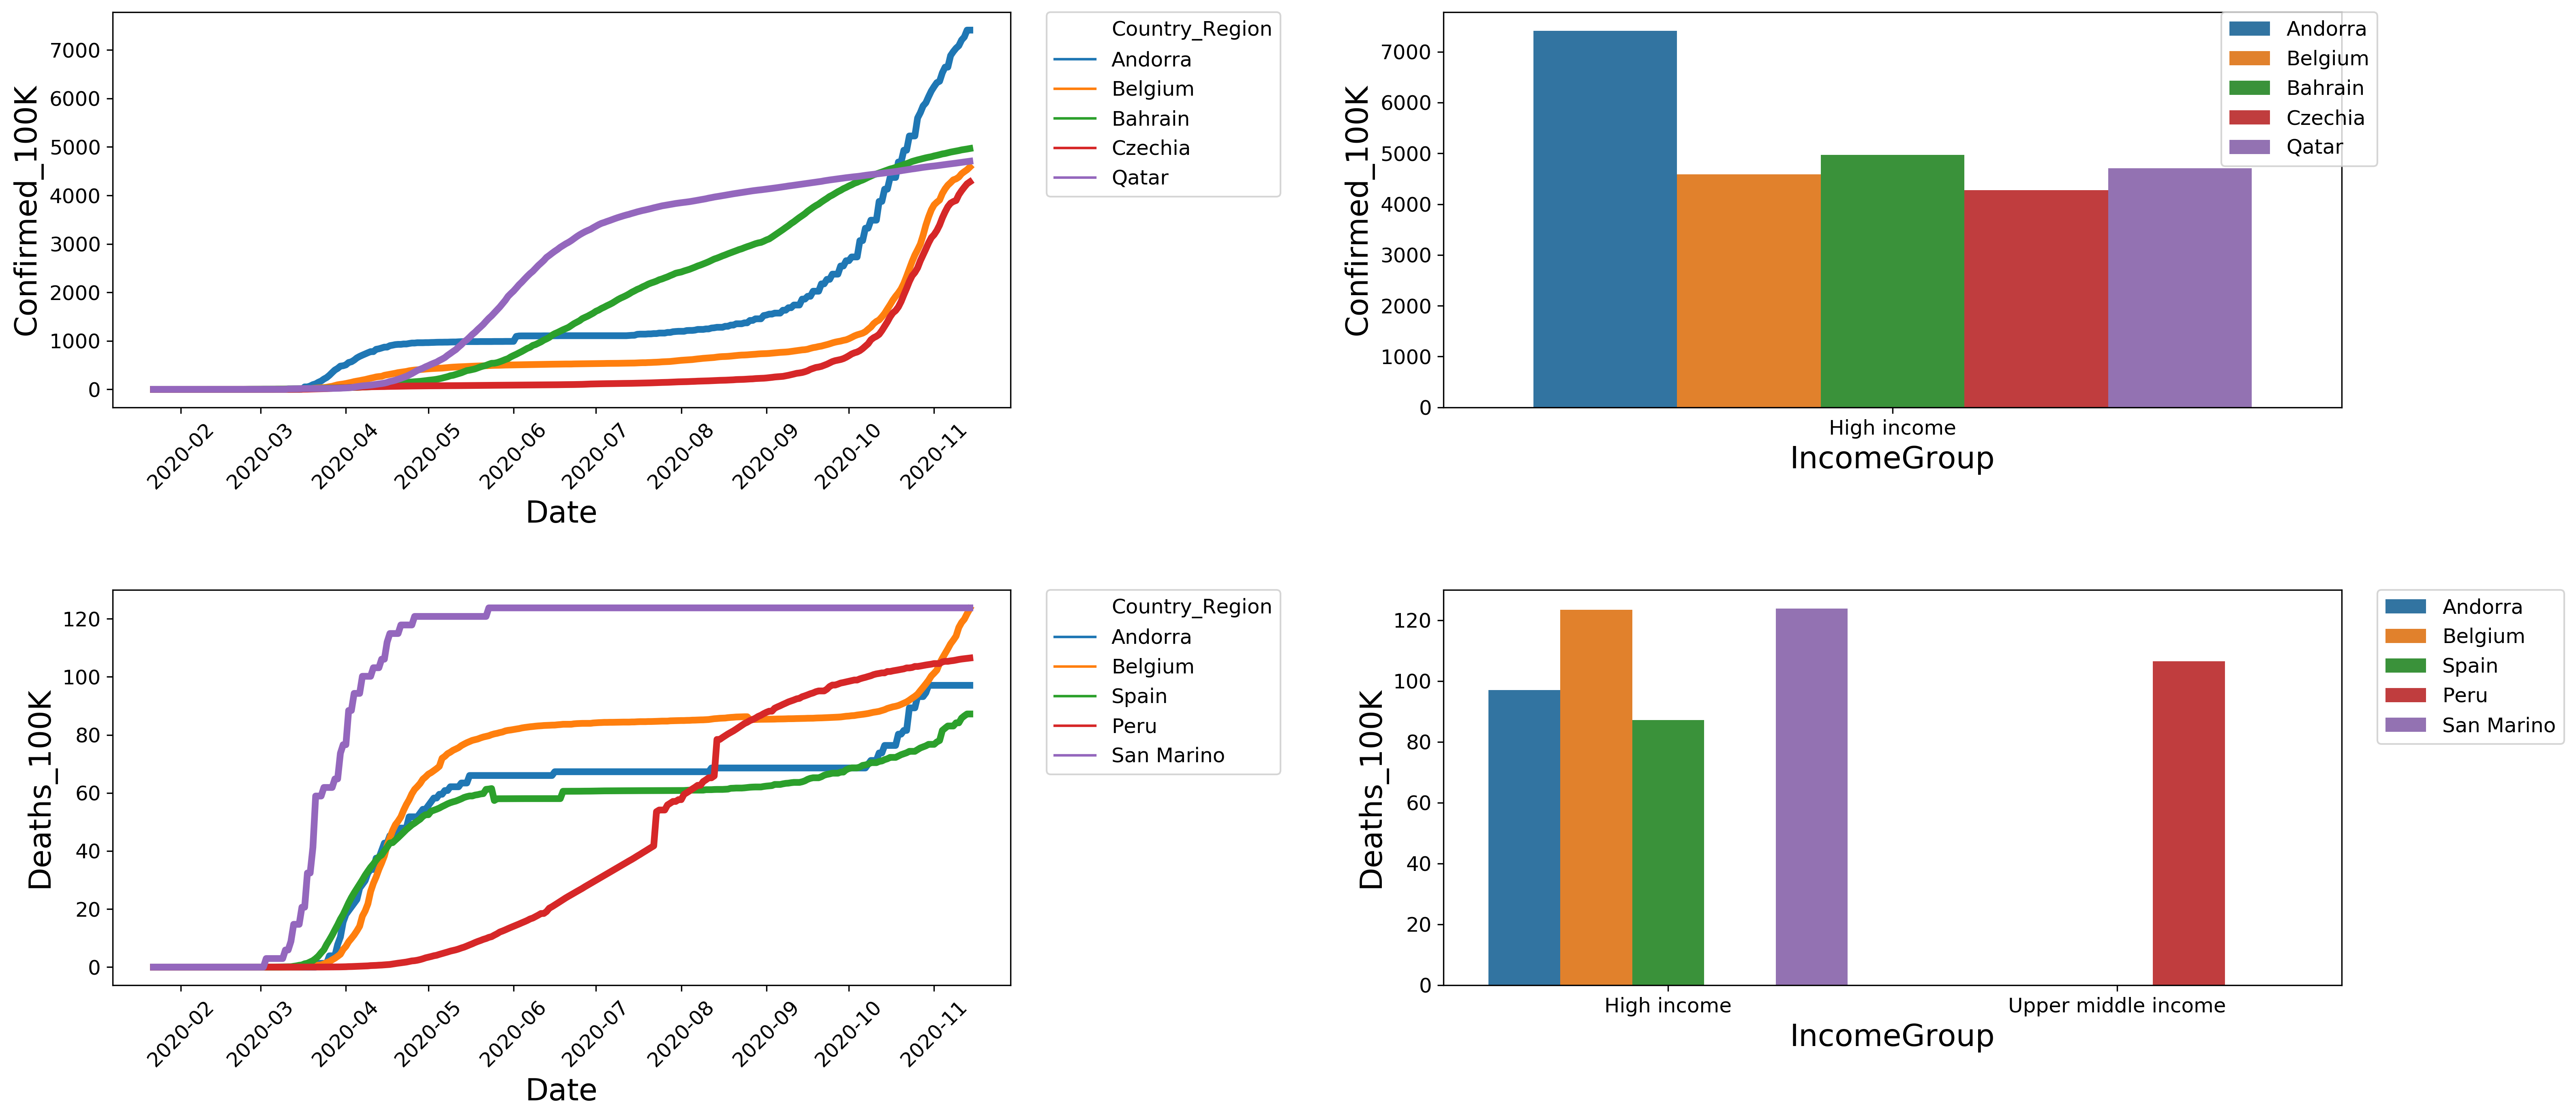

In [80]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top = 5
top_deaths_100K = my_final_df.loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df.loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]

top_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}
# plt.rc('font', **font)

factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=top_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=top_confirmed_100K_df[top_confirmed_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Confirmed_100K",
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=top_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=top_deaths_100K_df[top_deaths_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Deaths_100K",
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Most_affected_countries.png')

## Plotting the top ten LESS affected countries and Inconme level


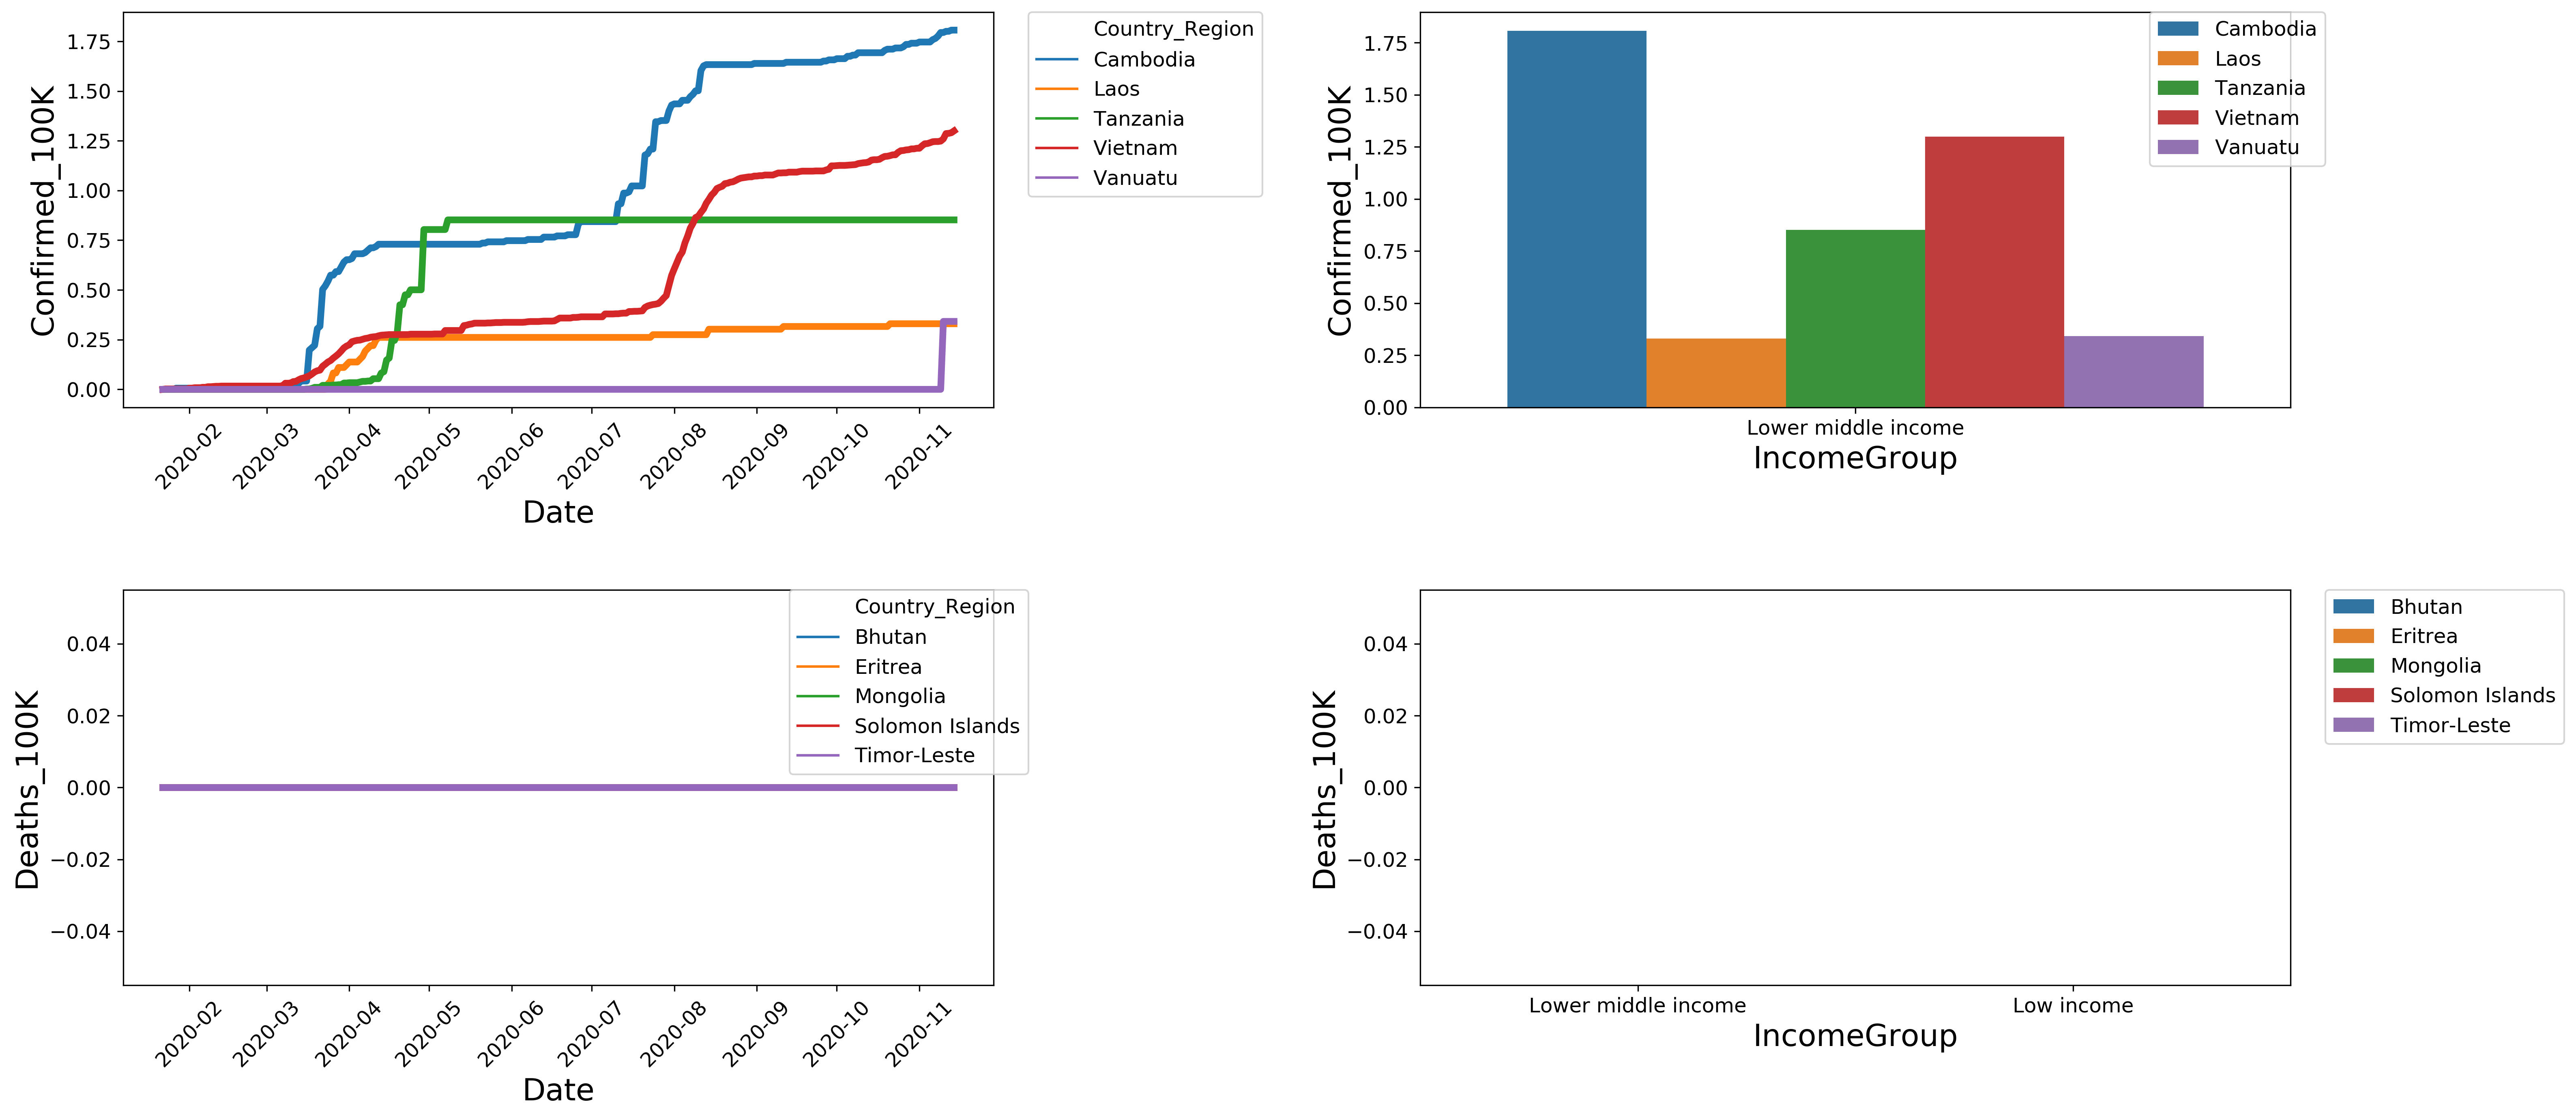

In [81]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 5
top_deaths_100K = my_final_df.loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df.loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]

top_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}
# plt.rc('font', **font)

factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=top_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=top_confirmed_100K_df[top_confirmed_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Confirmed_100K",
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=top_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=top_deaths_100K_df[top_deaths_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Deaths_100K",
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Less_affected_countries.png')

## NOTE: We found that the less affected countries seem to be countries with missed information (no reported cases) or very small populated countries. 

## Beacuse of this, we remove countries with small population size (< 1e6 people)

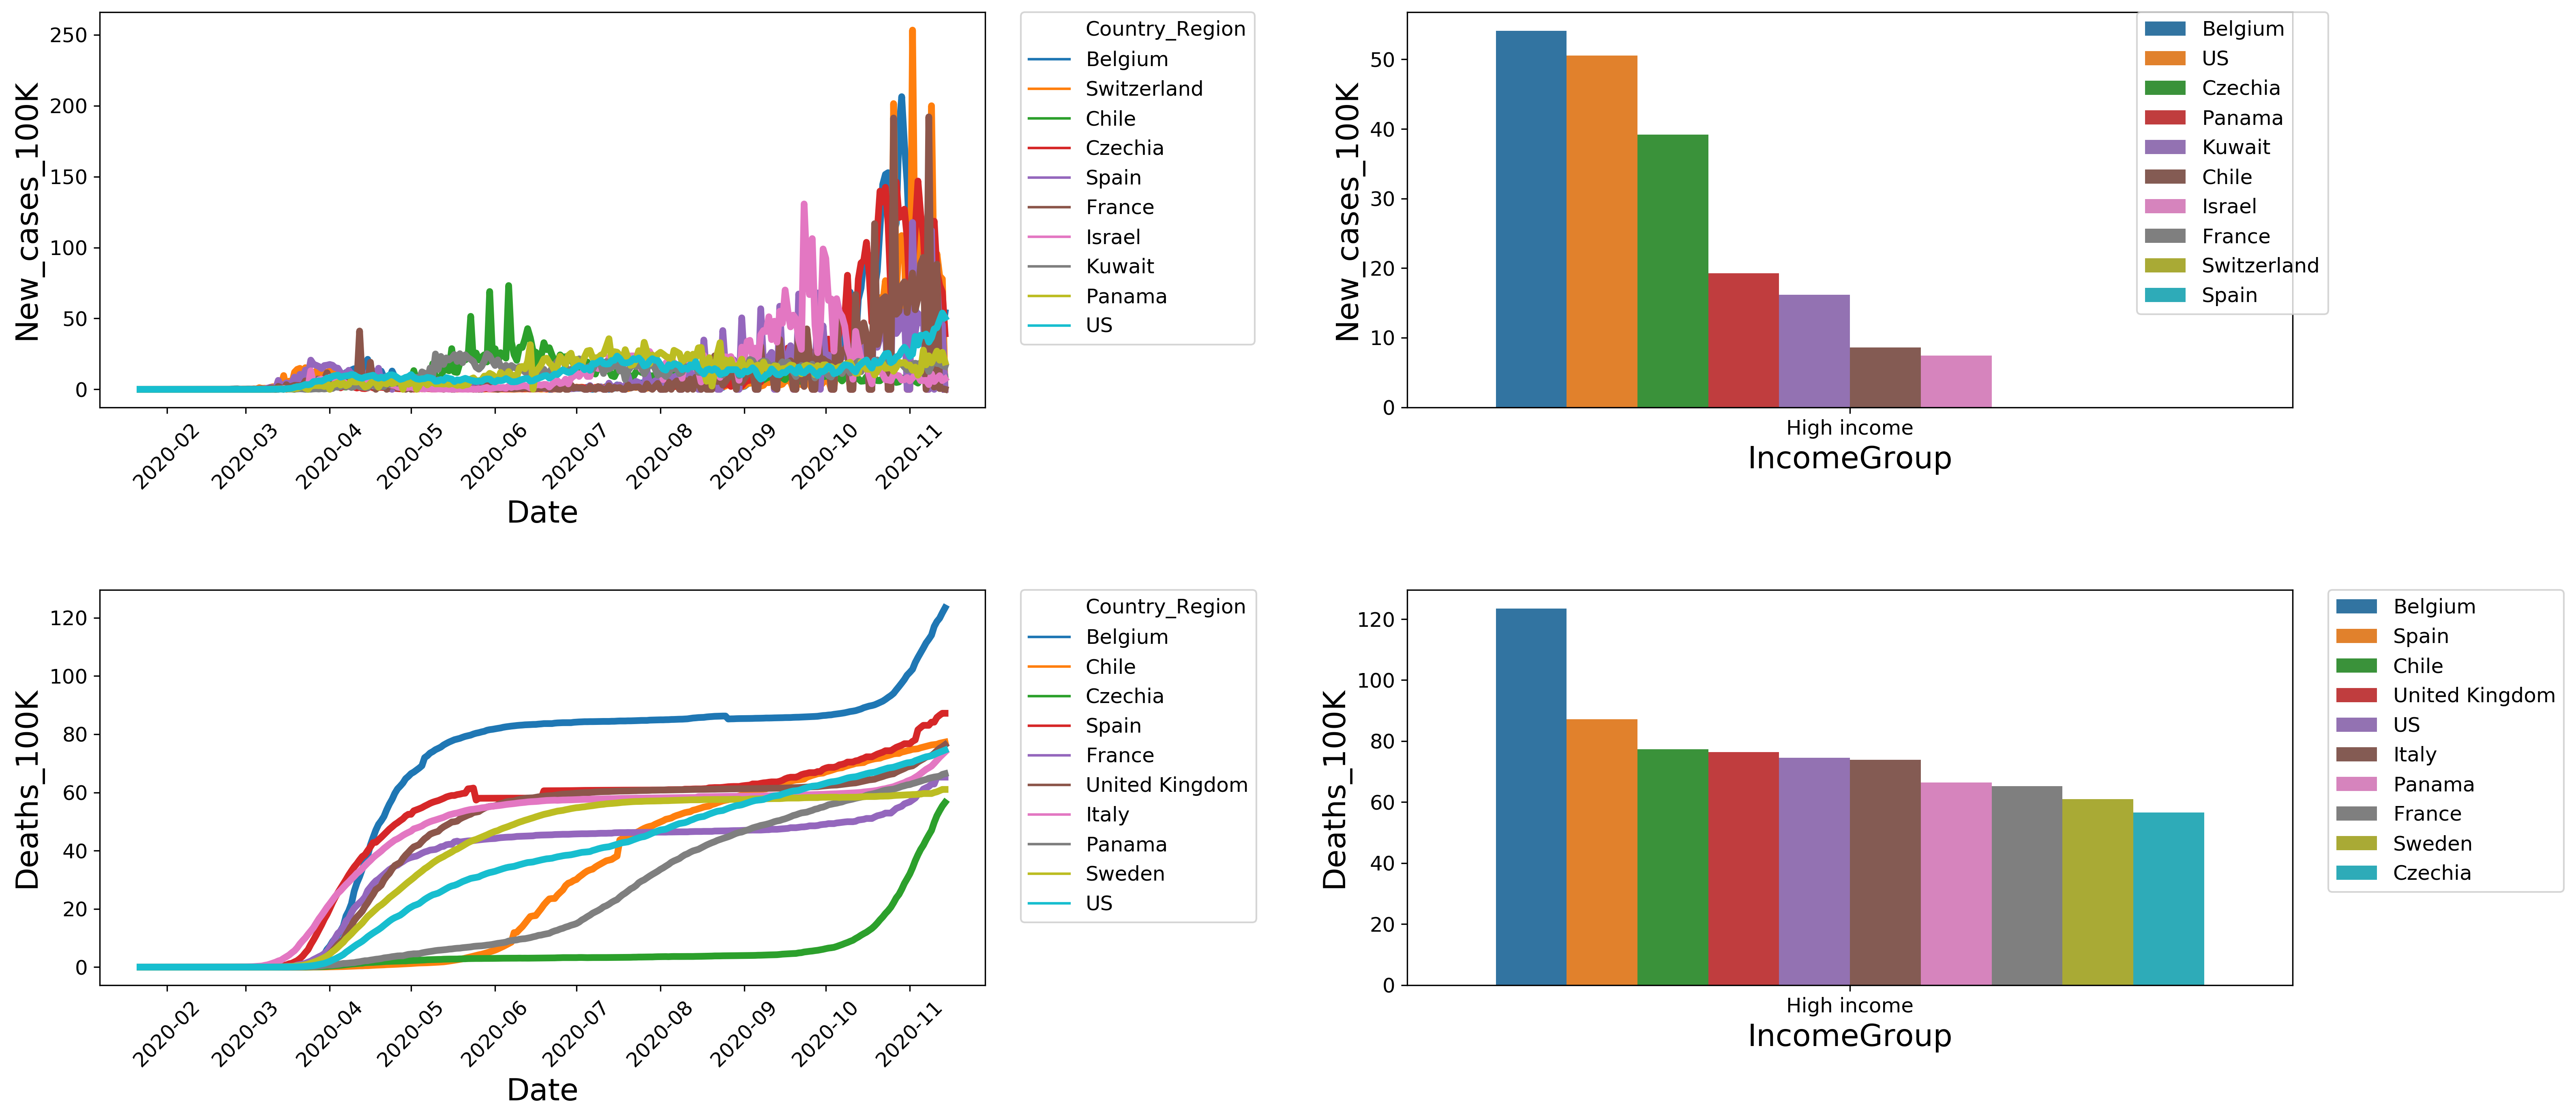

In [82]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 10
filt_popul = 3e6
best_10_confirmed=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = False).head(my_top_n).reset_index()['CountryCode'].to_list()
best_10_deaths=my_final_df[(my_final_df['IncomeGroup'] == 'High income')& (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = False).head(my_top_n).reset_index()['CountryCode'].to_list()

best_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()

my_var_to_plot_row_1 = "New_cases_100K"
my_var_to_plot_row_2 = "Deaths_100K"




factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    #y="Confirmed_100K",
    y=my_var_to_plot_row_1,
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=best_confirmed_100K_df[best_confirmed_100K_df['Date'] == last_reported_date].sort_values(by = my_var_to_plot_row_1, ascending = False), 
    x="IncomeGroup", 
    y=my_var_to_plot_row_1,
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y=my_var_to_plot_row_2,
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=best_deaths_100K_df[best_deaths_100K_df['Date'] == last_reported_date].sort_values(by = my_var_to_plot_row_2, ascending = False), 
    x="IncomeGroup", 
    y=my_var_to_plot_row_2,
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Real_Less_affected_countries.png')

In [83]:
my_var_to_plot_row_3 = my_final_df.columns.to_list()[5:19]
my_var_to_plot_row_3

['Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'New_cases',
 'New_deaths',
 'New_recovered',
 'Confirmed_100K',
 'Deaths_100K',
 'Recovered_100K',
 'Active_100K',
 'New_cases_100K',
 'New_deaths_100K',
 'New_recovered_100K']

## Checking the High income countries and find out what is the best stringency index pattern

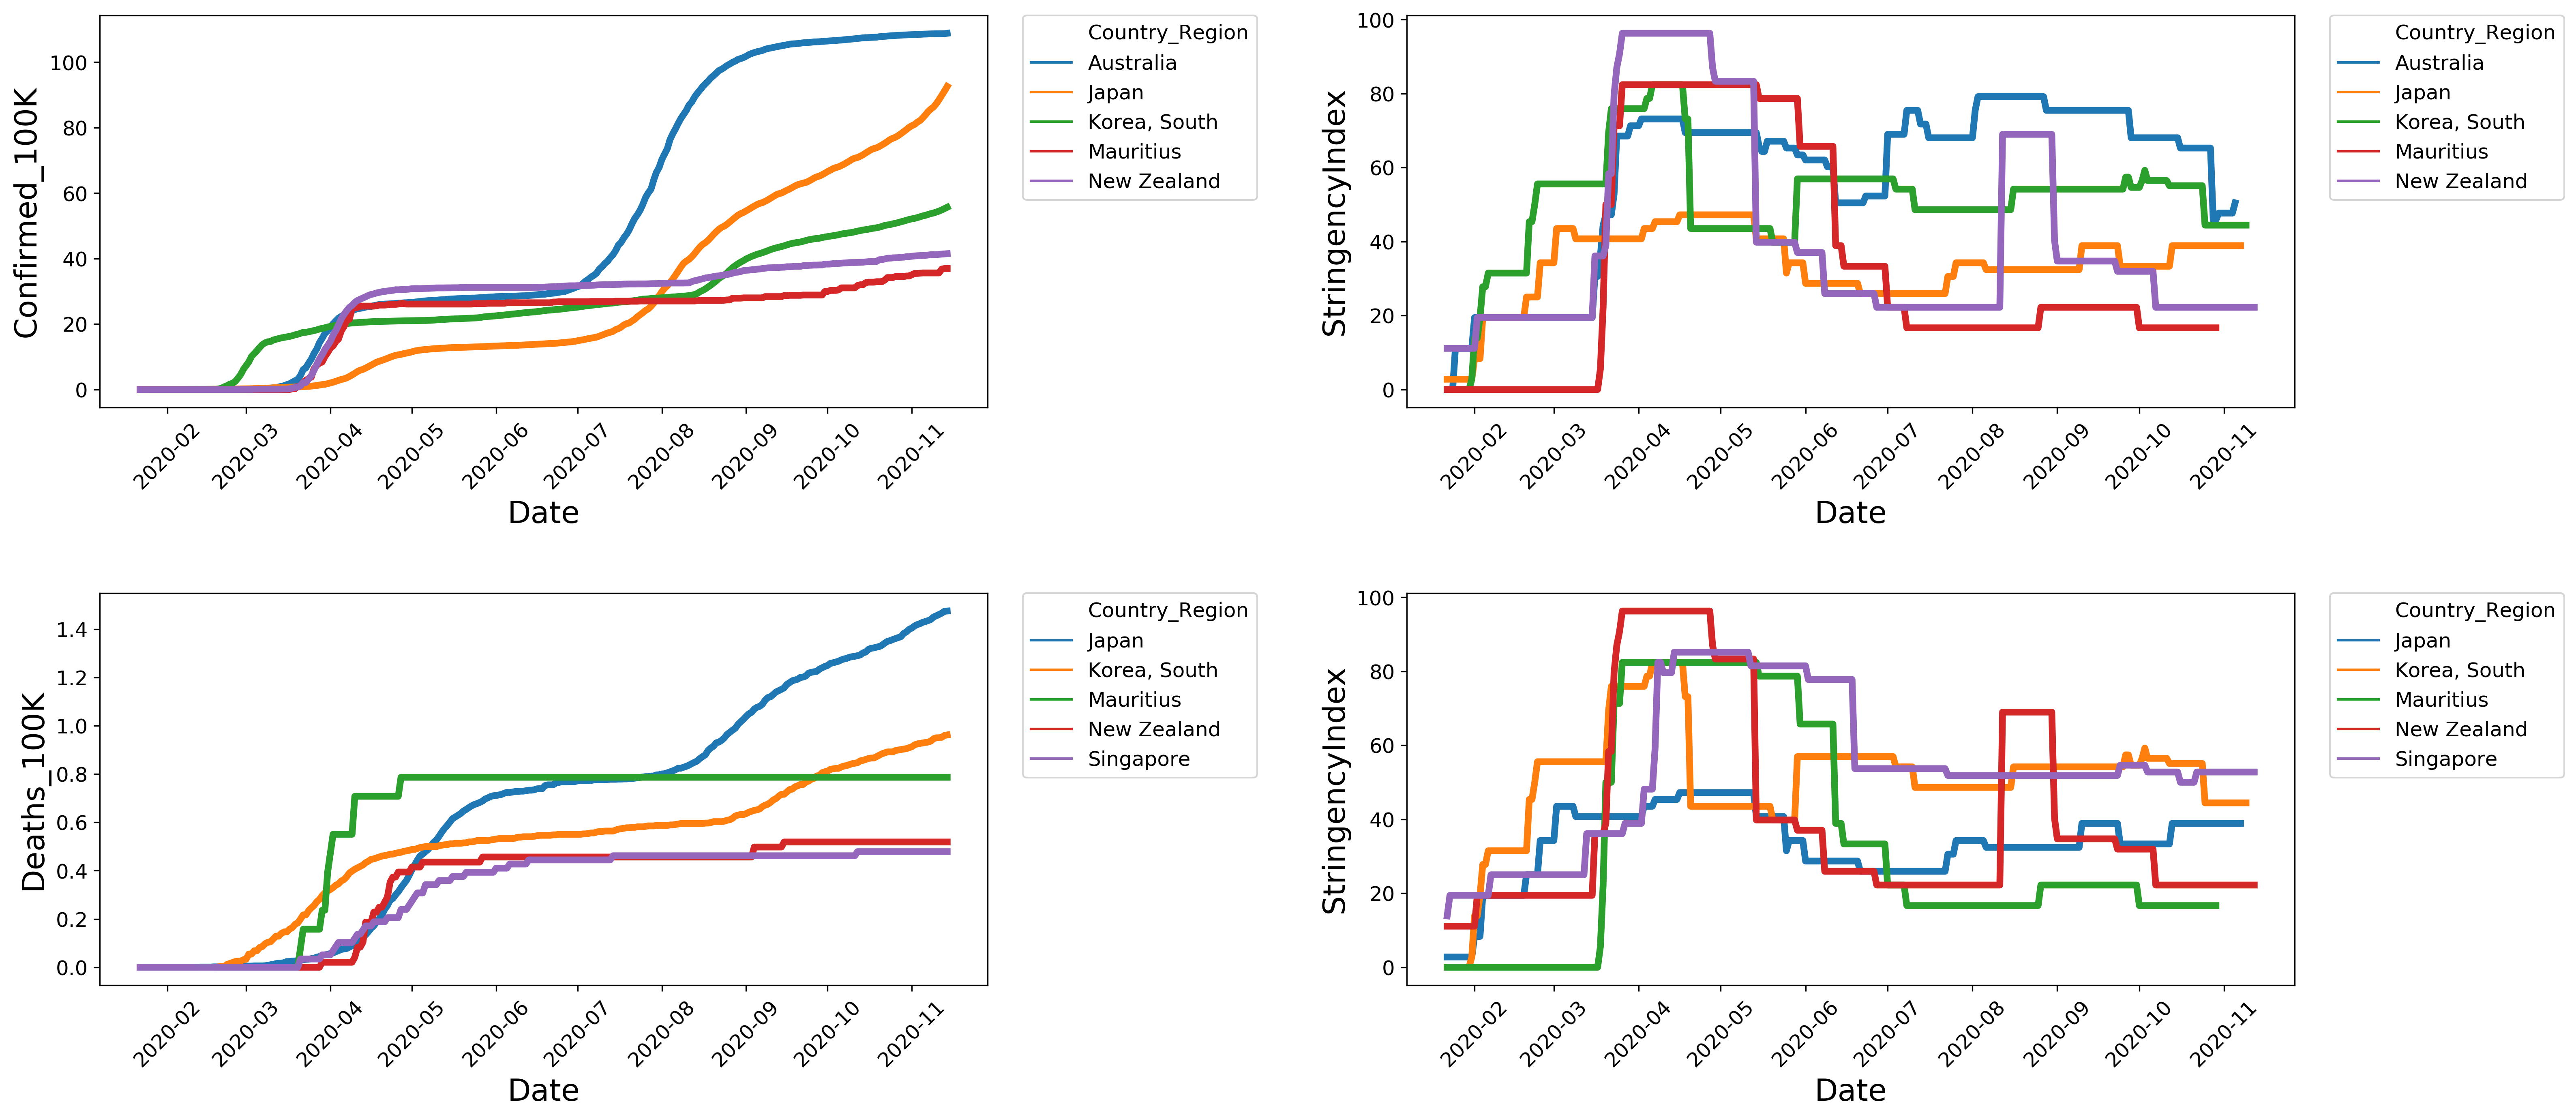

In [84]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 5

best_10_confirmed=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= 1000000)].loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()
best_10_deaths=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= 1000000)].loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()

best_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()



factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="StringencyIndex",
    ax = ax2,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax3 = fig1.add_subplot(223)
sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="StringencyIndex",
    ax = ax4,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('best_perfarmance.png')

# END

# Experimental

In [85]:
my_var_to_plot = my_final_df.columns.to_list()[5:19]
my_var_to_plot

['Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'New_cases',
 'New_deaths',
 'New_recovered',
 'Confirmed_100K',
 'Deaths_100K',
 'Recovered_100K',
 'Active_100K',
 'New_cases_100K',
 'New_deaths_100K',
 'New_recovered_100K']

In [86]:
my_var_to_plot[0]

'Confirmed'

In [87]:
my_top_n = 10
filt_popul = 3e6

In [88]:
my_final_df[ (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Confirmed", ascending = False).head(my_top_n)#.reset_index()['CountryCode'].to_list()


CountryCode  StringencyIndex StringencyIndex_factor  \
Date                                                             
2020-11-14         USA              NaN                unknown   
2020-11-14         IND              NaN                unknown   
2020-11-14         BRA              NaN                unknown   
2020-11-14         FRA            78.70                   High   
2020-11-14         RUS              NaN                unknown   
2020-11-14         ESP              NaN                unknown   
2020-11-14         GBR              NaN                unknown   
2020-11-14         ARG              NaN                unknown   
2020-11-14         COL            65.74                   High   
2020-11-14         ITA              NaN                unknown   

            Country_Region    Population   Confirmed    Deaths  Recovered  \
Date                                                                        
2020-11-14              US  3.294663e+08  10903890.0  245598.0  4148444.0   
2020-11-14           India  1.380004e+09   8814579.0  129635.0  8205728.0   
2020-11-14          Brazil  2.125594e+08   5848959.0  165658.0  5279452.0   
2020-11-14          France  6.527351e+07   1915713.0   42600.0   139760.0   
2020-11-14          Russia  1.459345e+08   1887836.0   32536.0  1415213.0   
2020-11-14           Spain  4.675478e+07   1458591.0   40769.0   150376.0   
2020-11-14  United Kingdom  6.788600e+07   1347907.0   51858.0     3108.0   
2020-11-14       Argentina  4.519578e+07   1304846.0   35307.0  1119366.0   
2020-11-14        Colombia  5.088288e+07   1191634.0   33829.0  1097576.0   
2020-11-14           Italy  6.046183e+07   1144552.0   44683.0   411434.0   

               Active  New_cases  ...  New_recovered  Confirmed_100K  \
Date                              ...                                  
2020-11-14  6509848.0   166555.0  ...        53298.0     3309.561725   
2020-11-14   479216.0    41100.0  ...        42156.0      638.735579   
2020-11-14   403849.0    38307.0  ...         4640.0     2751.682002   
2020-11-14  1733353.0       36.0  ...            0.0     2934.901067   
2020-11-14   440087.0    22441.0  ...        18362.0     1293.619067   
2020-11-14  1267446.0        0.0  ...            0.0     3119.661576   
2020-11-14  1292941.0    26876.0  ...           19.0     1985.544767   
2020-11-14   150173.0     8468.0  ...         8889.0     2887.097173   
2020-11-14    60229.0     8937.0  ...         8236.0     2341.915211   
2020-11-14   688435.0    37249.0  ...        12196.0     1893.015871   

            Deaths_100K  Recovered_100K  Active_100K  New_cases_100K  \
Date                                                                   
2020-11-14    74.544199     1259.140681  1975.876846       50.552973   
2020-11-14     9.393811      594.616082    34.725687        2.978251   
2020-11-14    77.934917     2483.753613   189.993471       18.021785   
2020-11-14    65.263839      214.114417  2655.522810        0.055153   
2020-11-14    22.294940      969.759302   301.564826       15.377451   
2020-11-14    87.197496      321.626987  2710.837092        0.000000   
2020-11-14    76.389826        4.578263  1904.576678       39.589898   
2020-11-14    78.120131     2476.704848   332.272194       18.736264   
2020-11-14    66.484046     2157.063267   118.367898       17.563863   
2020-11-14    73.902827      680.485545  1138.627499       61.607466   

            New_deaths_100K  New_recovered_100K    GDP_in_USD  \
Date                                                            
2020-11-14         0.384258           16.177073  2.137442e+13   
2020-11-14         0.032391            3.054773  2.875142e+12   
2020-11-14         0.433291            2.182919  1.839758e+12   
2020-11-14         0.000000            0.000000  2.715518e+12   
2020-11-14         0.260391           12.582361  1.699877e+12   
2020-11-14         0.000000            0.000000  1.394116e+12   
2020-11-14         0.680553            0.02

In [89]:
def sort_df_by(a_df, sorted_by, my_top = my_top_n, date = last_reported_date, popul = filt_popul):
    my_countries = a_df[ (a_df['Population'] >= popul)].loc[date].sort_values(by = sorted_by, ascending = False).head(my_top).reset_index()['CountryCode'].to_list()# select the names of the countries you want for later filtering
    a_df = a_df.loc[a_df['CountryCode'].isin(my_countries)]#.reset_index()

    return(a_df)



In [90]:
last_reported_date

'2020-11-14'

In [91]:
sort_df_by(a_df = my_final_df, 
#            my_top = 5,
#            date = last_reported_date,
           sorted_by = my_var_to_plot[4])

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         BRA              0.0               Very_low         Brazil   
2020-01-23         BRA              0.0               Very_low         Brazil   
2020-01-24         BRA              0.0               Very_low         Brazil   
2020-01-25         BRA              0.0               Very_low         Brazil   
2020-01-26         BRA              0.0               Very_low         Brazil   
...                ...              ...                    ...            ...   
2020-11-10         USA              NaN                unknown             US   
2020-11-11         USA              NaN                unknown             US   
2020-11-12         USA              NaN                unknown             US   
2020-11-13         USA              NaN                unknown             US   
2020-11-14         USA              NaN                unknown             US   

             Population   Confirmed    Deaths  Recovered     Active  \
Date                                                                  
2020-01-22  212559409.0         0.0       0.0        0.0        0.0   
2020-01-23  212559409.0         0.0       0.0        0.0        0.0   
2020-01-24  212559409.0         0.0       0.0        0.0        0.0   
2020-01-25  212559409.0         0.0       0.0        0.0        0.0   
2020-01-26  212559409.0         0.0       0.0        0.0        0.0   
...                 ...         ...       ...        ...        ...   
2020-11-10  329466283.0  10256094.0  240589.0  3961873.0  6053632.0   
2020-11-11  329466283.0  10399325.0  241977.0  3997175.0  6160173.0   
2020-11-12  329466283.0  10560111.0  243194.0  4051256.0  6265661.0   
2020-11-13  329466283.0  10737335.0  244332.0  4095146.0  6397857.0   
2020-11-14  329466283.0  10903890.0  245598.0  4148444.0  6509848.0   

            New_cases  ...  New_recovered  Confirmed_100K  Deaths_100K  \
Date                   ...                                               
2020-01-22        0.0  ...            0.0        0.000000     0.000000   
2020-01-23        0.0  ...            0.0        0.000000     0.000000   
2020-01-24        0.0  ...            0.0        0.000000     0.000000   
2020-01-25        0.0  ...            0.0        0.000000     0.000000   
2020-01-26        0.0  ...            0.0        0.000000     0.000000   
...               ...  ...            ...             ...          ...   
2020-11-10   140290.0  ...        33028.0     3112.941909    73.023861   
2020-11-11   143231.0  ...        35302.0     3156.415553    73.445148   
2020-11-12   160786.0  ...        54081.0     3205.217512    73.814534   
2020-11-13   177224.0  ...        43890.0     3259.008753    74.159941   
2020-11-14   166555.0  ...        53298.0     3309.561725    74.544199   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000000        0.000000         0.000000   
2020-01-23        0.000000     0.000000        0.000000         0.000000   
2020-01-24        0.000000     0.000000        0.000000         0.000000   
2020-01-25        0.000000     0.000000        0.000000         0.000000   
2020-01-26        0.000000     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2020-11-10     1202.512428  1837.405620       42.580988         0.424930   
2020-11-11     1213.227333  1869.743072       43.473644         0.421287   
2020-11-12     1229.642063  1901.760916       48.801959         0.369385   
2020-11-13     1242.963609  1941.885203       53.791240         0.345407   
2020-11-14     1259.140681  1975.876846       50.552973         0.384258   

            New_recovered_100K    GDP_in_USD          IncomeGroup  
Date         

In [92]:
my_var_to_plot

['Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'New_cases',
 'New_deaths',
 'New_recovered',
 'Confirmed_100K',
 'Deaths_100K',
 'Recovered_100K',
 'Active_100K',
 'New_cases_100K',
 'New_deaths_100K',
 'New_recovered_100K']

In [110]:
#my_final_df[my_final_df["CountryCode"].isin(["ARG", "VEN"])]
my_countries_dicc

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'AND': 'Andorra',
 'ARE': 'United Arab Emirates',
 'ARG': 'Argentina',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BIH': 'Bosnia and Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'Central African Republic',
 'CHE': 'Switzerland',
 'CHL': 'Chile',
 'CHN': 'China',
 'CIV': "Cote d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'Congo (Kinshasa)',
 'COG': 'Congo (Brazzaville)',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CYP': 'Cyprus',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DJI': 'Djibouti',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'ECU': 'Ecuador',
 'E

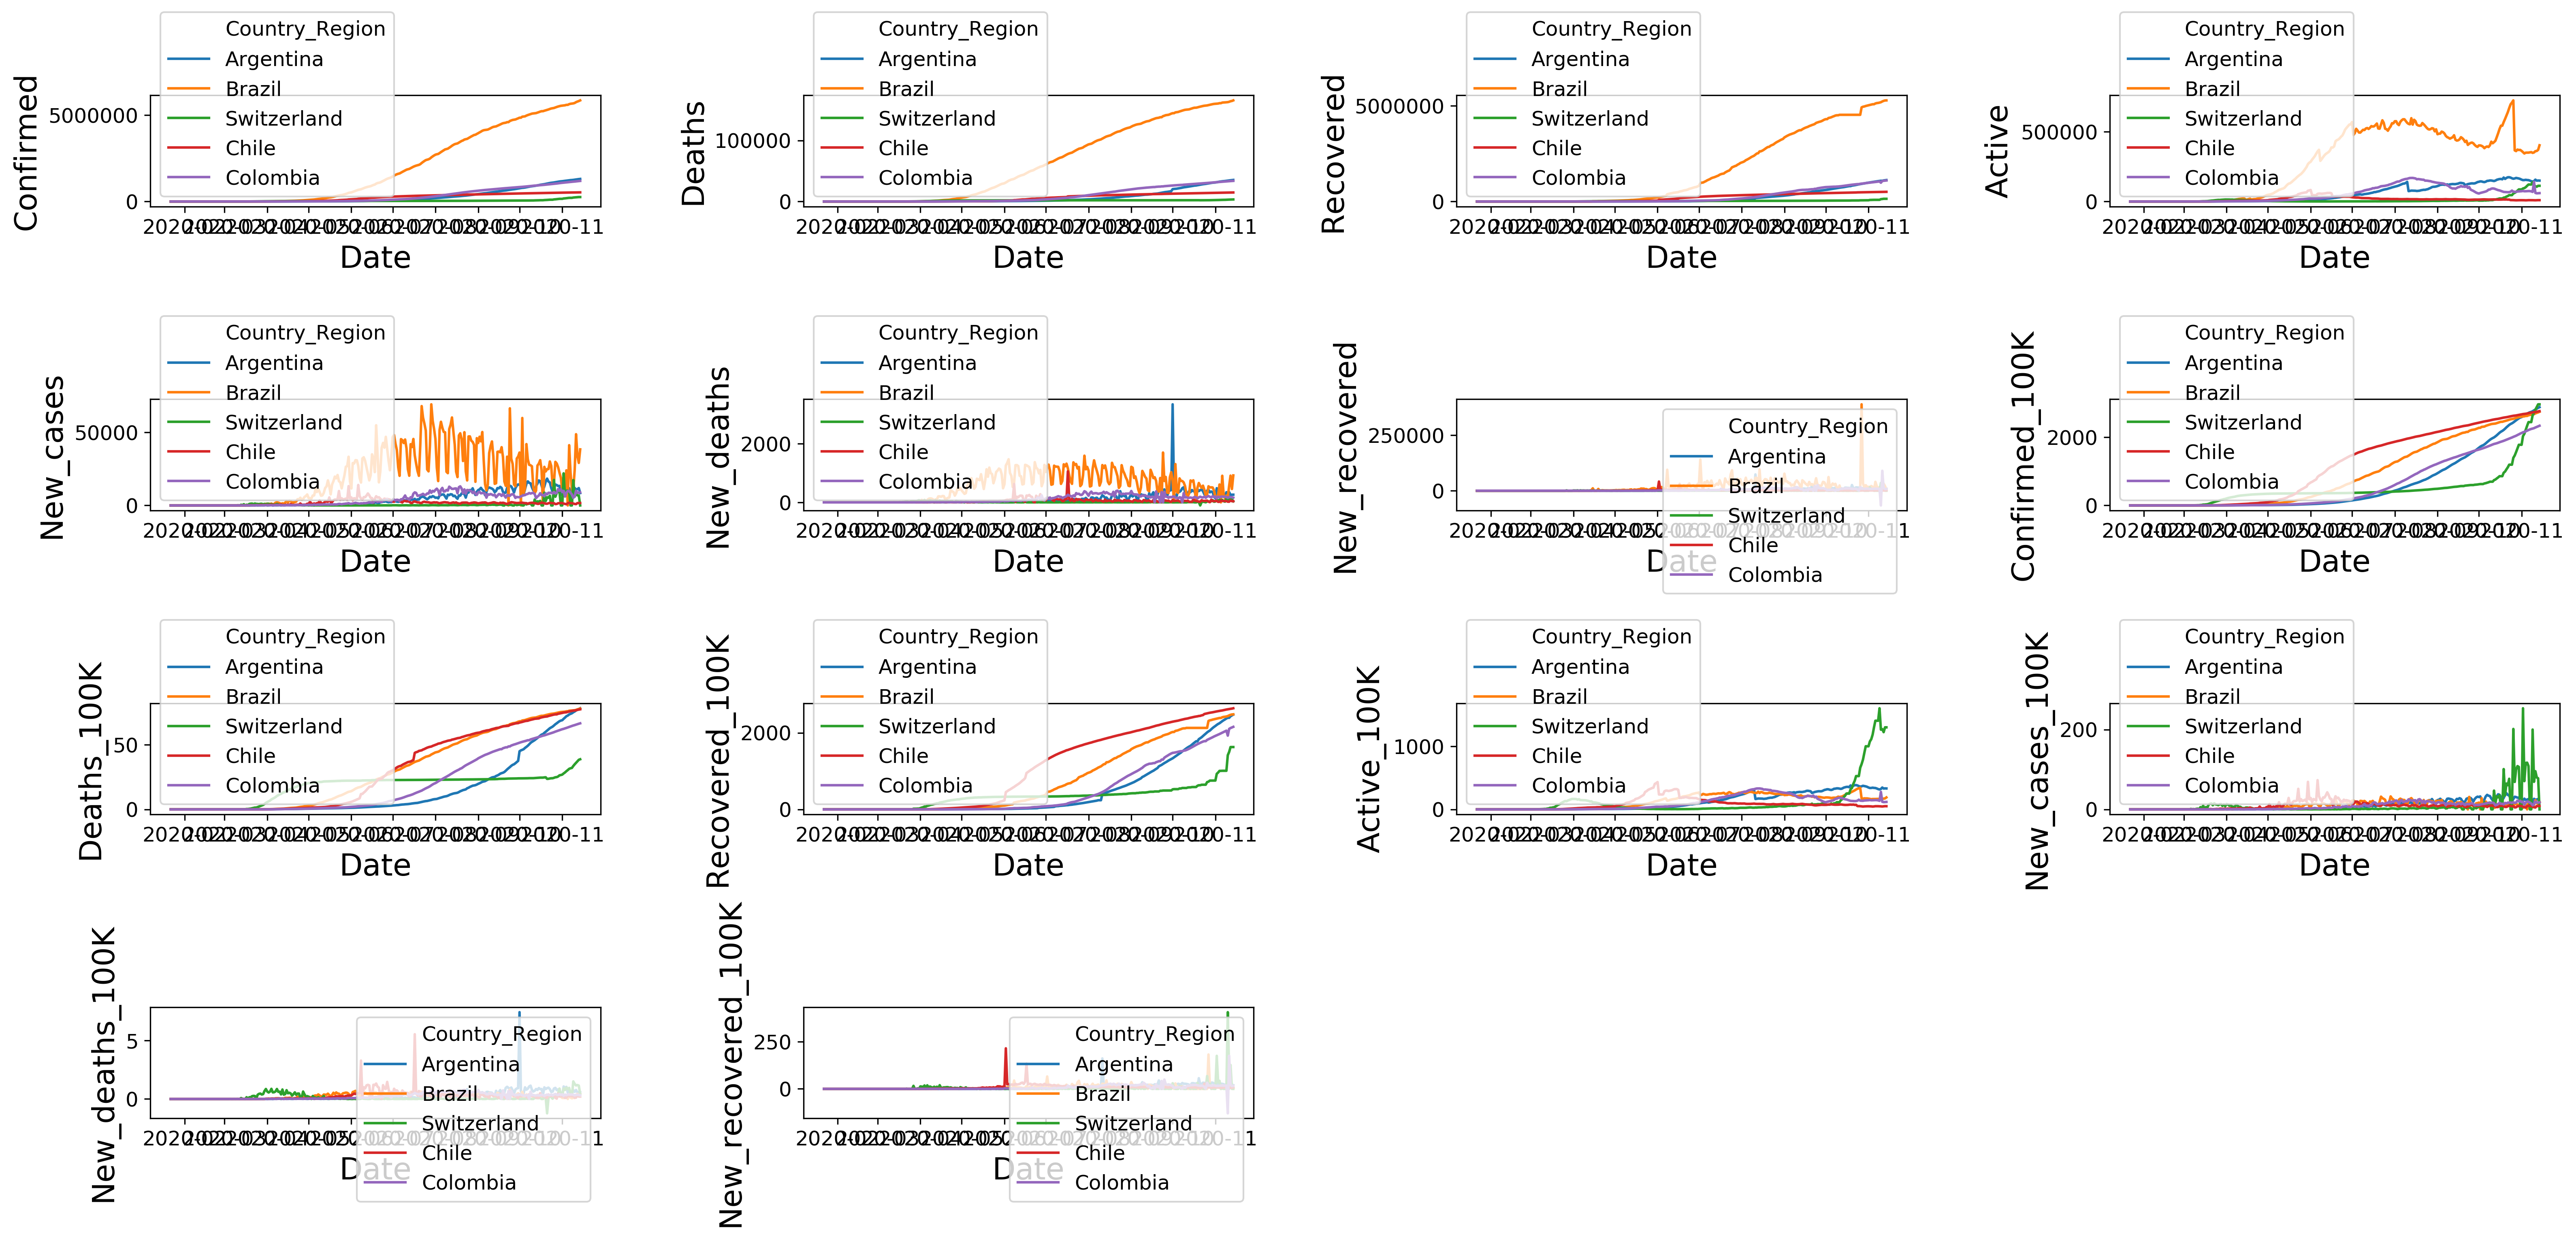

In [114]:
fig1 = plt.figure(figsize=(22, 10) , dpi=300)
for n in range(len(my_var_to_plot)):
    #my_df = sort_df_by(a_df = my_final_df, my_top = 5, sorted_by = my_var_to_plot[n])
    my_df = my_final_df[my_final_df["CountryCode"].isin(["ARG", "COL", "CHL", "BRA", "CHE", "GER"])]
    
    ax = fig1.add_subplot(4, 4, n + 1)
    sb.lineplot(data=my_df.reset_index(),
                x="Date",
                y=my_var_to_plot[n],
                #linewidth = my_line_width,
                hue="Country_Region")
fig1.tight_layout(pad=3)

In [96]:
def my_multiplots_func(my_df, my_vars, dim = 4):
    fig1 = plt.figure(figsize=(22, 10) , dpi=300)
    #print(dim)
    my_axes = []
    for my_var in range(len(my_vars)):
        #my_axes.append(fig1.add_subplot(dim, dim, n + 1))
        ax = fig1.add_subplot(dim, dim, my_var + 1)
        
    #for my_var in range(len(my_vars)):
        
        
        
#     for my_var in range(len(my_vars)):
#         ax[my_var + 1] = fig1.add_subplot(dim, dim, my_var + 1)
#         my_df = sort_df_by(a_df = my_df, 
#                            sorted_by = my_vars[my_var])
#         fig1.add_subplot(dim, dim, my_var + 1)
#         sb.lineplot(
#         data=best_confirmed_100K_df, 
#         #     kind="line",
#         x="Date", 
#         #y="Confirmed_100K",
#         y=my_var_to_plot[0],
#         ax = ax[my_var + 1],
#         linewidth = my_line_width,
#         hue="Country_Region")
    
    
    #fig1 = plt.figure(figsize=(22, 10) , dpi=300)
    
return(fig1)
# for my_vars in my_var_to_plot:
#     print(my_vars)

SyntaxError: 'return' outside function (<ipython-input-96-da8248d49b9f>, line 31)

In [ ]:
my_multiplots_func(my_df = my_final_df, my_vars = my_var_to_plot)

In [ ]:
my_var_to_plot[0:2]

In [ ]:
my_multiplots_func(my_var_to_plot)

In [ ]:
%who

In [ ]:
country